# Model_1_post_estimation

# Source links

website:
https://satyajitghana.medium.com/human-pose-estimation-and-quantization-of-pytorch-to-onnx-models-a-detailed-guide-b9c91ddc0d9f

google collab:
https://colab.research.google.com/drive/1uFLEw-p9Syui0GoDMsZSIoyiCyILVoCO?usp=sharing&source=post_page-----b9c91ddc0d9f--------------------------------#scrollTo=cRTcGFonX-kq

github repo:
https://github.com/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2/blob/master/05-HumanPoseEstimation-ONNX/HumanPoseEstimation_ONNX_Quant.ipynb

# Monocular Single Human Pose Estimation

In [2]:
! git clone https://github.com/microsoft/human-pose-estimation.pytorch && cd human-pose-estimation.pytorch && git checkout 18f1d0fa5b5db7fe08de640610f3fdbdbed8fb2f

Cloning into 'human-pose-estimation.pytorch'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 197 (delta 1), reused 7 (delta 0), pack-reused 188
Receiving objects: 100% (197/197), 73.71 KiB | 3.68 MiB/s, done.
Resolving deltas: 100% (87/87), done.
Note: switching to '18f1d0fa5b5db7fe08de640610f3fdbdbed8fb2f'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 18f1d0f Update README.md


In [3]:
pip install onnx onnxruntime==1.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.0 MB/s eta 0:00:00


In [4]:
import sys
if "/content/human-pose-estimation.pytorch/lib/" not in sys.path:
    sys.path.insert(0, "/content/human-pose-estimation.pytorch/lib/")

In [5]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
import torchvision.transforms as T

import cv2

import re
import os
import copy
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [6]:
import models
from core.config import config
from core.config import update_config
from core.config import update_dir
from core.config import get_model_name

We are going to use MPII - ResNet50 Model trained on `256x256` sized images
model_file: https://drive.google.com/file/d/1V2AaVpDSn-eS7jrFScHLJ-wvTFuQ0-Dc/view?usp=sharing

In [7]:
! gdown https://drive.google.com/uc?id=1V2AaVpDSn-eS7jrFScHLJ-wvTFuQ0-Dc

Downloading...
From (original): https://drive.google.com/uc?id=1V2AaVpDSn-eS7jrFScHLJ-wvTFuQ0-Dc
From (redirected): https://drive.google.com/uc?id=1V2AaVpDSn-eS7jrFScHLJ-wvTFuQ0-Dc&confirm=t&uuid=a2e58791-d9b6-43bd-ba8c-dd5e04a2f452
To: /content/pose_resnet_50_256x256.pth.tar
100% 136M/136M [00:02<00:00, 59.5MB/s]


The corresponding config file is taken from experiments folder

In [9]:
CONFIG_FILE = '/content/human-pose-estimation.pytorch/experiments/mpii/resnet50/256x256_d256x3_adam_lr1e-3.yaml'
MODEL_PATH = '/content/pose_resnet_50_256x256.pth.tar'

In [ ]:
#update_config(CONFIG_FILE)
#config.GPUS = '' # we are running on CPU

Load the model

In [10]:
model = eval('models.'+config.MODEL.NAME+'.get_pose_net')(config, is_train=False)
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

In [12]:
model.summary()

PoseResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

In [16]:
# Iterate through each layer and print its details
for name, layer in model.named_children():
    print(f'Layer Name: {name.ljust(20)} | Type: {layer.__class__.__name__.ljust(20)} | Parameters: {sum(p.numel() for p in layer.parameters())}')
print('-'*50)
print(f'Total Parameters: {sum(p.numel() for p in model.parameters())}')

Layer Name: conv1                | Type: Conv2d               | Parameters: 9408
Layer Name: bn1                  | Type: BatchNorm2d          | Parameters: 128
Layer Name: relu                 | Type: ReLU                 | Parameters: 0
Layer Name: maxpool              | Type: MaxPool2d            | Parameters: 0
Layer Name: layer1               | Type: Sequential           | Parameters: 215808
Layer Name: layer2               | Type: Sequential           | Parameters: 1219584
Layer Name: layer3               | Type: Sequential           | Parameters: 7098368
Layer Name: layer4               | Type: Sequential           | Parameters: 14964736
Layer Name: deconv_layers        | Type: Sequential           | Parameters: 10487296
Layer Name: final_layer          | Type: Conv2d               | Parameters: 4112
--------------------------------------------------
Total Parameters: 33999440


Pose Lady

In [18]:
! wget https://i.pinimg.com/474x/e7/6d/92/e76d92d3f4055099e955c35d955e0a34.jpg -O pose.jpg

--2024-05-01 07:06:33--  https://i.pinimg.com/474x/e7/6d/92/e76d92d3f4055099e955c35d955e0a34.jpg
Resolving i.pinimg.com (i.pinimg.com)... 23.48.104.112, 23.48.104.113, 2a04:4e42:79::84
Connecting to i.pinimg.com (i.pinimg.com)|23.48.104.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12170 (12K) [image/jpeg]
Saving to: ‘pose.jpg’

pose.jpg            100%[===================>]  11.88K  --.-KB/s    in 0s      

2024-05-01 07:06:33 (87.4 MB/s) - ‘pose.jpg’ saved [12170/12170]



Pose Man

In [19]:
! wget https://habrastorage.org/webt/aa/xj/ls/aaxjls3wjnghu4ebwbjbquaz0hc.png -O pose.png

--2024-05-01 07:06:35--  https://habrastorage.org/webt/aa/xj/ls/aaxjls3wjnghu4ebwbjbquaz0hc.png
Resolving habrastorage.org (habrastorage.org)... 51.89.30.72, 65.109.153.168, 65.21.120.121
Connecting to habrastorage.org (habrastorage.org)|51.89.30.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211894 (207K) [image/png]
Saving to: ‘pose.png’

pose.png            100%[===================>] 206.93K   697KB/s    in 0.3s    

2024-05-01 07:06:36 (697 KB/s) - ‘pose.png’ saved [211894/211894]



And this is me

In [20]:
! wget https://github.com/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2/blob/master/05-HumanPoseEstimation-ONNX/satyajit-pose-small.jpg?raw=true -O satyajit-pose.jpg

--2024-05-01 07:06:36--  https://github.com/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2/blob/master/05-HumanPoseEstimation-ONNX/satyajit-pose-small.jpg?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2/raw/master/05-HumanPoseEstimation-ONNX/satyajit-pose-small.jpg [following]
--2024-05-01 07:06:37--  https://github.com/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2/raw/master/05-HumanPoseEstimation-ONNX/satyajit-pose-small.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2/master/05-HumanPoseEstimation-ONNX/satyajit-pose-small.jpg [following]
--2024-05-01 07:06:37--  https://raw.githubusercontent.com/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2/master

In [21]:
IMAGE_FILE = 'satyajit-pose.jpg'

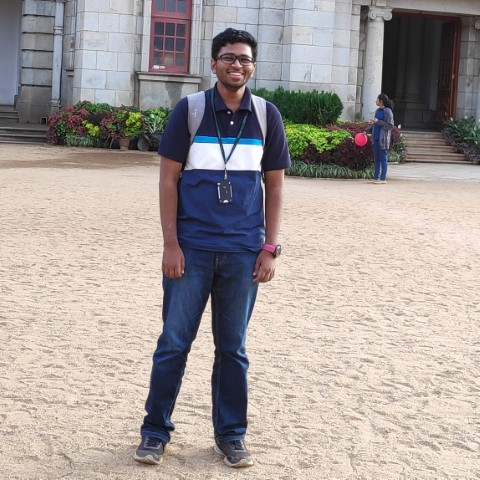

In [22]:
image = Image.open(IMAGE_FILE)
image = image.convert('RGB')
image

In [23]:
transform = T.Compose([
                       T.Resize((256, 256)),
                       T.ToTensor(),
                       T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                       ])

Transform the image for the model

In [24]:
tr_img = transform(image)

In [25]:
tr_img.shape

torch.Size([3, 256, 256])

In [26]:
tr_img[0]

tensor([[-0.7993, -0.7993, -0.7993,  ..., -0.1999, -0.1999, -0.2513],
        [-0.7822, -0.7822, -0.7822,  ..., -0.0801, -0.0629, -0.0801],
        [-0.7479, -0.7479, -0.7650,  ...,  0.0056,  0.0056, -0.0116],
        ...,
        [ 1.6667,  1.5982,  1.4954,  ...,  1.6153,  1.0502,  1.1700],
        [ 1.4612,  1.5468,  1.3242,  ...,  1.9064,  1.5468,  1.2043],
        [ 1.6495,  1.5639,  1.3755,  ...,  1.6495,  1.8722,  1.8893]])

Pass the Image through the model

In [27]:
output = model(tr_img.unsqueeze(0))
output = output.squeeze(0)

In [28]:
output.shape

torch.Size([16, 64, 64])

In [29]:
_, OUT_HEIGHT, OUT_WIDTH = output.shape
output.shape

torch.Size([16, 64, 64])

In [30]:
get_detached = lambda x: copy.deepcopy(x.cpu().detach().numpy())

In [31]:
get_detached

<function __main__.<lambda>(x)>

`joint_id` - name
taken from: http://human-pose.mpi-inf.mpg.de/#download

In [32]:
JOINTS = ['0 - r ankle', '1 - r knee', '2 - r hip', '3 - l hip', '4 - l knee', '5 - l ankle', '6 - pelvis', '7 - thorax', '8 - upper neck', '9 - head top', '10 - r wrist', '11 - r elbow', '12 - r shoulder', '13 - l shoulder', '14 - l elbow', '15 - l wrist']
JOINTS = [re.sub(r'[0-9]+|-', '', joint).strip().replace(' ', '-') for joint in JOINTS]

In [33]:
POSE_PAIRS = [
# UPPER BODY
              [9, 8],
              [8, 7],
              [7, 6],

# LOWER BODY
              [6, 2],
              [2, 1],
              [1, 0],

              [6, 3],
              [3, 4],
              [4, 5],

# ARMS
              [7, 12],
              [12, 11],
              [11, 10],

              [7, 13],
              [13, 14],
              [14, 15]
]

In [34]:
from operator import itemgetter
get_keypoints = lambda pose_layers: map(itemgetter(1, 3), [cv2.minMaxLoc(pose_layer) for pose_layer in pose_layers])

In [35]:
get_keypoints

<function __main__.<lambda>(pose_layers)>

Here are all the detections

(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)


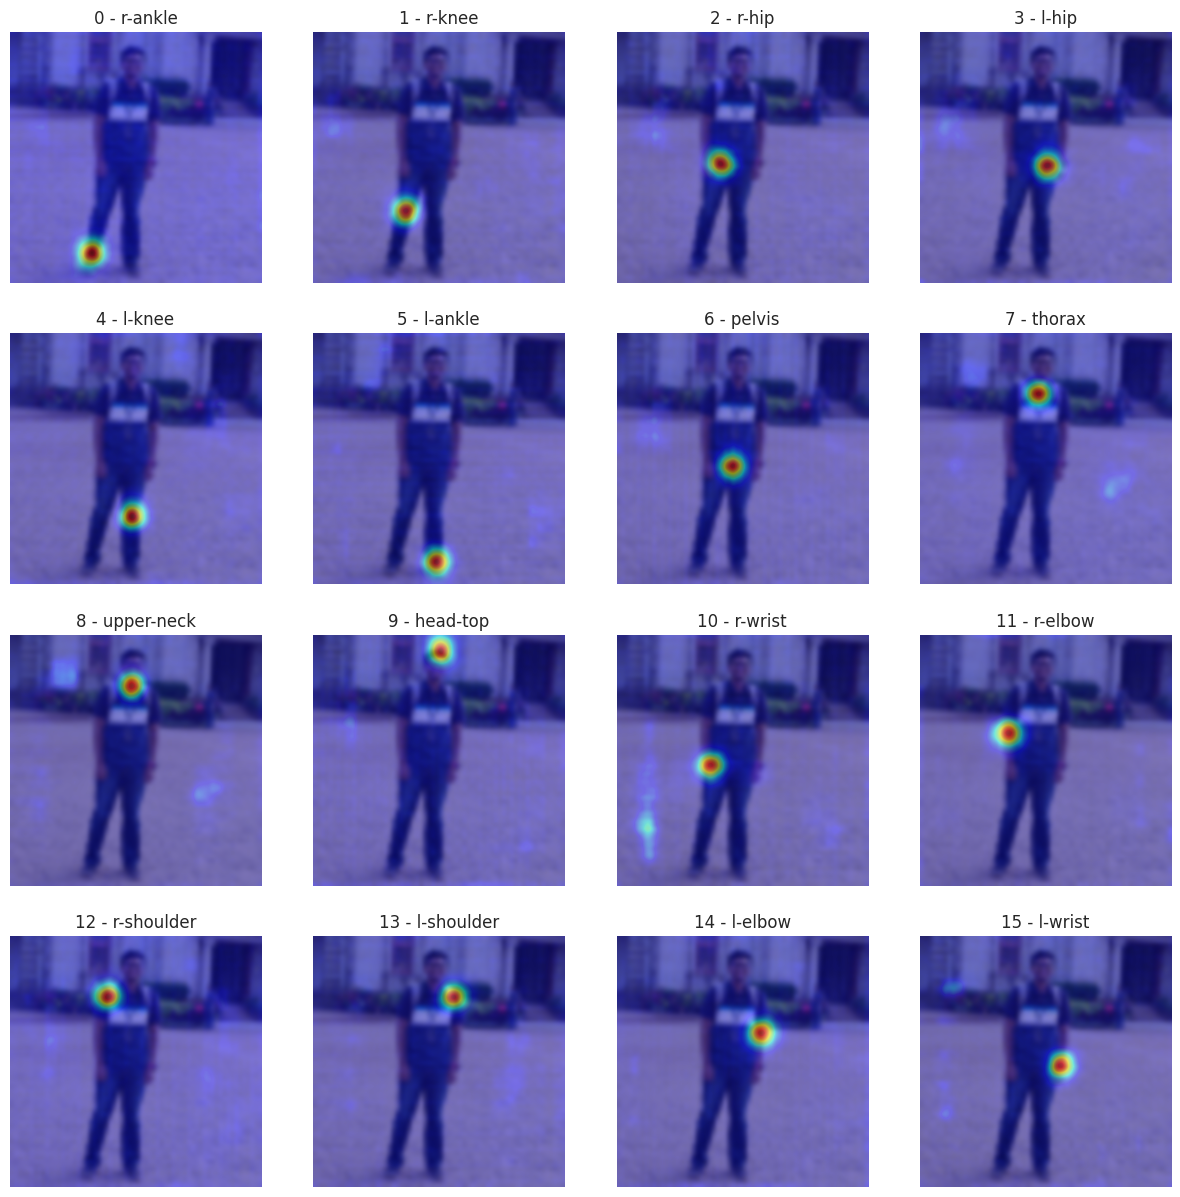

In [36]:
plt.figure(figsize=(15, 15))
for idx, pose_layer in enumerate(get_detached(output)):
    # print(pose_layer.shape)
    plt.subplot(4, 4, idx + 1)
    plt.title(f'{idx} - {JOINTS[idx]}')
    plt.imshow(image.resize((OUT_WIDTH, OUT_HEIGHT)), cmap='gray', interpolation='bicubic')
    print(pose_layer.shape)
    plt.imshow(pose_layer, alpha=0.5, cmap='jet', interpolation='bicubic')
    plt.axis('off')
plt.show()

Here are the detections summarised in a single image

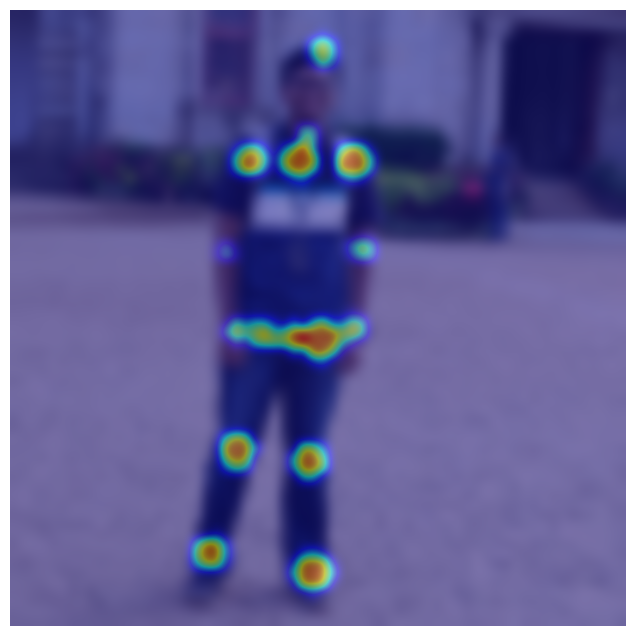

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(image.resize((OUT_WIDTH, OUT_HEIGHT)), cmap='gray', interpolation='bicubic')
pose_layers = get_detached(output)
pose_layers = np.clip(pose_layers, 0.7, 1.0)
layer_sum = np.sum(pose_layers, axis=0)
plt.imshow(layer_sum, alpha=0.5, cmap='jet', interpolation='bicubic')
plt.axis('off')
plt.show()

Now we will connect these detected regions

In [ ]:
THRESHOLD = 0.8
OUT_SHAPE = (OUT_HEIGHT, OUT_WIDTH)
image_p = cv2.imread(IMAGE_FILE)
pose_layers = get_detached(x=output)
key_points = list(get_keypoints(pose_layers=pose_layers))
is_joint_plotted = [False for i in range(len(JOINTS))]
for pose_pair in POSE_PAIRS:
    from_j, to_j = pose_pair

    from_thr, (from_x_j, from_y_j) = key_points[from_j]
    to_thr, (to_x_j, to_y_j) = key_points[to_j]

    IMG_HEIGHT, IMG_WIDTH, _ = image_p.shape

    from_x_j, to_x_j = from_x_j * IMG_WIDTH / OUT_SHAPE[0], to_x_j * IMG_WIDTH / OUT_SHAPE[0]
    from_y_j, to_y_j = from_y_j * IMG_HEIGHT / OUT_SHAPE[1], to_y_j * IMG_HEIGHT / OUT_SHAPE[1]

    from_x_j, to_x_j = int(from_x_j), int(to_x_j)
    from_y_j, to_y_j = int(from_y_j), int(to_y_j)

    if from_thr > THRESHOLD and not is_joint_plotted[from_j]:
        # this is a joint
        cv2.ellipse(image_p, (from_x_j, from_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[from_j] = True

    if to_thr > THRESHOLD and not is_joint_plotted[to_j]:
        # this is a joint
        cv2.ellipse(image_p, (to_x_j, to_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[to_j] = True

    if from_thr > THRESHOLD and to_thr > THRESHOLD:
        # this is a joint connection, plot a line
        cv2.line(image_p, (from_x_j, from_y_j), (to_x_j, to_y_j), (255, 74, 0), 3)

### Our final image with the estimated pose !

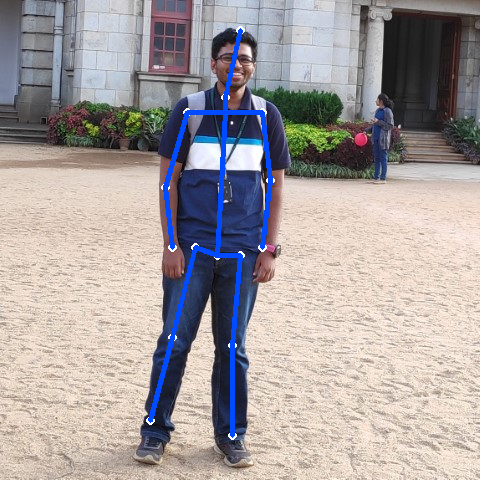

In [ ]:
Image.fromarray(cv2.cvtColor(image_p, cv2.COLOR_RGB2BGR))

## Convert to ONNX and quantize the model

In [ ]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

def print_size_of_onnx_model(model):
    onnx.save(model, 'temp.onnx')
    print('Size (MB):', os.path.getsize("temp.onnx")/1e6)
    os.remove('temp.onnx')

PyTorch Model Size

In [ ]:
print_size_of_model(model)

Size (MB): 136.303756


In [ ]:
new_model = copy.deepcopy(model)

Now we will Convert this model to ONNX

In [ ]:
import io
import numpy as np
import torch.onnx

In [ ]:
# Input to the model
torch_model = new_model
batch_size = 1
x = torch.randn(batch_size, 3, 256, 256, requires_grad=True)
torch_out = torch_model(x)

# Export the model
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "simple_pose_estimation.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})

In [ ]:
import onnx

onnx_model = onnx.load("simple_pose_estimation.onnx")
onnx.checker.check_model(onnx_model)

Let's just check the size of the saved ONNX Model

In [ ]:
print_size_of_onnx_model(onnx_model)

Size (MB): 135.924959


And also lets quicky test if the model works

In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("simple_pose_estimation.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(tr_img.unsqueeze(0))}
ort_outs = ort_session.run(None, ort_inputs)

In [ ]:
ort_outs = ort_outs[0][0]

In [ ]:
len(ort_outs)

16

Google Collab Link:

https://colab.research.google.com/drive/1X30qpMcayu7nPL7O9UoIpgvtM0XjvR4J?usp=sharing